In [177]:
import pandas as pd
import numpy as np
import wrds
import seaborn as sns
import matplotlib.pyplot as plt

# Imports

In [128]:
# file imports
file_path_forecasts = '../data/dataset2014-2022-v4.zip'
file_path_company = '../data/dataset-company-industry-data-v1.csv'

# IBES forecasts
df_forecasts = pd.read_csv(file_path_forecasts)

# SIC codes
df_companies = pd.read_csv(file_path_company)

In [129]:
df_forecasts

,TICKER,CUSIP,OFTIC,CNAME,ESTIMATOR,ANALYS,FPI,MEASURE,VALUE,FPEDATS,REVDATS,ANNDATS,ACTUAL,ANNDATS_ACT
0,0000,87482X10,TLMR,TALMER BANCORP,2500,72481,1,EPS,1.200,2014-12-31,2014-12-03,2014-12-03,1.21,2015-01-30
1,0000,87482X10,TLMR,TALMER BANCORP,2500,72481,1,EPS,0.850,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26
2,0000,87482X10,TLMR,TALMER BANCORP,149,119962,1,EPS,0.860,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26
3,0000,87482X10,TLMR,TALMER BANCORP,1267,71182,1,EPS,0.890,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26
4,0000,87482X10,TLMR,TALMER BANCORP,149,119962,1,EPS,0.890,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570994,ZYNX,98986M10,ZYXI,ZYNEX INC,2709,122730,1,EPS,0.460,2022-12-31,2022-07-29,2022-07-29,0.44,2023-03-13
1570995,ZYNX,98986M10,ZYXI,ZYNEX INC,926,118308,1,EPS,0.420,2022-12-31,2023-01-18,2022-07-29,0.44,2023-03-13
1570996,ZYNX,98986M10,ZYXI,ZYNEX,220,193620,1,EPS,0.423,2022-12-31,2023-01-06,2022-10-27,0.44,2023-03-13
1570997,ZYNX,98986M10,ZYXI,ZYNEX,2709,122730,1,EPS,0.440,2022-12-31,2022-10-28,2022-10-28,0.44,2023-03-13


In [130]:
df_companies

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,curcd,fyr,costat,sic,spcindcd
0,1004,2014-05-31,2013.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
1,1004,2015-05-31,2014.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
2,1004,2016-05-31,2015.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
3,1004,2017-05-31,2016.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
4,1004,2018-05-31,2017.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115407,353742,2021-11-30,2021.0,INDL,C,D,STD,LIFFF,53000A106,CAD,11.0,A,1400.0,NaN
115408,353742,2022-11-30,2022.0,INDL,C,D,STD,LIFFF,53000A106,CAD,11.0,A,1400.0,NaN
115409,353945,2021-12-31,2021.0,INDL,C,D,STD,ACLLY,00449R109,USD,12.0,A,3621.0,NaN
115410,353945,2022-12-31,2022.0,INDL,C,D,STD,ACLLY,00449R109,USD,12.0,A,3621.0,NaN


In [178]:
# setup WRDS database connection for linking table
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [35]:
# import linking information table
link_table = db.get_table(library = "comp", table = "security")
link_table = link_table[["gvkey", "iid", "ibtic"]]
link_table.head()

,gvkey,iid,ibtic
0,001000,01,None
1,001001,01,AMFD
2,001002,01,None
3,001003,01,ANTQ
4,001004,01,AIR


# Preprocessing
df_forecasts:
- Lower case all columns in df_forecasts
- Drop unncessary columns
- Include only forecasts issued no earlier than 1 year ahead and no later than 30 days before fiscal year end
- Rename columns
- Delete rows with actual_eps = NAN or estimated_eps = NAN
- (Exclude forecasts for companies which only one analyst provides a forecast)
- Exclude all analysts appearing in the initial 2-3 years of the dataset (migitating problem of experience)
- (Retain the last forecast an analyst issues in a particular year)
- ...

In [132]:
df_forecasts = df_forecasts.rename(columns={col: col.lower() for col in df_forecasts.columns})

# Drop unncessary columns
columns_to_drop = ["fpi","measure","cusip"]
df_forecasts = df_forecasts.drop(columns=columns_to_drop)

In [133]:
# convert columns with dates to datetime
def convert_to_datetime(df):
    columns_to_convert = ['fpedats','revdats', "anndats", 'anndats_act']
    for column in columns_to_convert:
        df[column] = pd.to_datetime(df[column])
    return df
df_forecasts = convert_to_datetime(df_forecasts)

# filter forecasts  based on time
df_forecasts['difference_date'] = df_forecasts['fpedats'] - df_forecasts['anndats']
df_forecasts = df_forecasts[(df_forecasts['difference_date']> pd.Timedelta(days=30))&(df_forecasts['difference_date']<pd.Timedelta(days=365))]
df_forecasts.head()

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,difference_date
1,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
2,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
3,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days
4,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days
5,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days


In [134]:
# rename columns
df_forecasts = df_forecasts.rename(columns={"ticker": "ibes_ticker_pk", "oftic": "official_ticker", "analys": "analyst", 
                                  "value": "estimated_eps", "fpedats": "fiscal_period_ending", 
                                  "revdats": "revision_date", "anndats": "announce_date", 
                                  "actual": "actual_eps", "anndats_act": "announce_date_actual",
                                  "difference_date": "forecast_horizon"})

In [135]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon
1,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
2,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
3,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days
4,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days
5,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days


In [136]:
# drop all rows where the actual_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['actual_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['actual_eps'])

Number of rows dropped:  39738


In [137]:
# drop all rows where the estimated_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['estimated_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['estimated_eps'])

Number of rows dropped:  11


In [139]:
df_companies

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,curcd,fyr,costat,sic,spcindcd
0,1004,2014-05-31,2013.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
1,1004,2015-05-31,2014.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
2,1004,2016-05-31,2015.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
3,1004,2017-05-31,2016.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
4,1004,2018-05-31,2017.0,INDL,C,D,STD,AIR,000361105,USD,5.0,A,5080.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115407,353742,2021-11-30,2021.0,INDL,C,D,STD,LIFFF,53000A106,CAD,11.0,A,1400.0,NaN
115408,353742,2022-11-30,2022.0,INDL,C,D,STD,LIFFF,53000A106,CAD,11.0,A,1400.0,NaN
115409,353945,2021-12-31,2021.0,INDL,C,D,STD,ACLLY,00449R109,USD,12.0,A,3621.0,NaN
115410,353945,2022-12-31,2022.0,INDL,C,D,STD,ACLLY,00449R109,USD,12.0,A,3621.0,NaN


## Merging Industry Codes to IBES Forecasts

Get the PK of Compustat (gvkey) and append it to IBES dataframe with linking table provided by WRDS

In [71]:
# distinct ibtic values in link_table and distinct ibes_ticker_pk in df_forecasts
print("Number of distinct ibtic values in link_table: ", link_table['ibtic'].nunique())
print("Number of distinct ibes_ticker_pk values in df_forecasts: ", df_forecasts['ibes_ticker_pk'].nunique())

Number of distinct ibtic values in link_table:  27146
Number of distinct ibes_ticker_pk values in df_forecasts:  7255


In [72]:
# ibtic values that are in both link_table and df_forecasts
link_table_ibtic = link_table['ibtic'].unique()
df_forecasts_ibtic = df_forecasts['ibes_ticker_pk'].unique()
print("Number of ibtic values in link_table that are also in df_forecasts: ", len(set(link_table_ibtic).intersection(df_forecasts_ibtic)))

Number of ibtic values in link_table that are also in df_forecasts:  6027


In [73]:
# extract ibes_ticker_pk values that are not in link_table
ibtic_not_in_link_table = set(df_forecasts_ibtic).difference(link_table_ibtic)
len(ibtic_not_in_link_table)

1228

### Comment: Kick does we cant map?
the iid value comes more then once for one gvkey or ticker value, this means that it creates more rows with link join

stats on link_table:
- 53543 of unique gvkeys
- 32298 dont have a corresponding ibtick -> is not needed since is not used for join
- 564 companies in df_forecast will have more than one value for a gvkey

In [165]:
link_table[link_table['gvkey']=='001045']

,gvkey,ibtic
49,001045,None
51,001045,AMR


In [164]:
# clear link table before matching
link_table = link_table[['gvkey', 'ibtic']].drop_duplicates()

In [166]:
gvkey_ibtic_counts = link_table.groupby('gvkey')['ibtic'].nunique()

# Filter groups having more than one distinct 'ibtic' value
gvkeys_with_multiple_ibtic = gvkey_ibtic_counts[gvkey_ibtic_counts > 1]

# Display the results
link_table[link_table['gvkey']==gvkeys_with_multiple_ibtic]

gvkey
001081    2
001164    2
001186    2
001243    2
001440    2
         ..
266196    2
270281    2
287882    2
290977    2
329579    2
Name: ibtic, Length: 680, dtype: int64


In [173]:
messed_up_values = link_table[(link_table['gvkey'].isin(gvkeys_with_multiple_ibtic.index))&~link_table['ibtic'].isna()]

In [175]:
df_forecasts['official_ticker'][df_forecasts['ibes_ticker_pk'].isin(messed_up_values['ibtic'])].nunique()

564

In [176]:
df_forecasts['official_ticker'].nunique()

7831

In [74]:
# merge link table onto df_forecasts
merged_df = pd.merge(left = df_forecasts, right = link_table, how = "left", left_on="ibes_ticker_pk", right_on= "ibtic")
merged_df.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,gvkey,iid,ibtic
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,192458,01,0000
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,192458,01,0000


In [141]:
# metrics of successes
print("Number of rows df_forecasts: ", df_forecasts.shape[0])
print('Number of rows df_merged: ',  merged_df.shape[0])
print("Percentage of rows in merged_df that have no gvkey to total number of rows: ", round((merged_df['gvkey'].isna().sum()/df_forecasts.shape[0])*100,2), "%")

Number of rows df_forecasts:  1375251
Number of rows df_merged:  1376490
Percentage of rows in merged_df that have no gvkey to total number of rows:  0.0 %


### Merge SIC codes to IBES Forecasts table

In [77]:
df_companies.loc[df_companies['sic'].isna(), 'sic'] = -1 

In [78]:
# keep only first two integers of sic code for highest level of industry classification
df_companies['sic'] = df_companies['sic'].astype(str).str[:2]
df_companies['sic'] = df_companies['sic'].astype('int')
df_companies["sic"].head()

0    50
1    50
2    50
3    50
4    50
Name: sic, dtype: int64

In [81]:
# unique sic codes per gvkey in df_companies
sic_codes = df_companies[["gvkey", "sic"]].drop_duplicates().reset_index(drop=True)
sic_codes.head()

,gvkey,sic
0,1004,50
1,1019,73
2,1045,45
3,1050,35
4,1062,67


In [107]:
merged_df['official_ticker'][merged_df['gvkey']=='nan'].nunique()

1273

In [98]:
merged_df['gvkey'] = merged_df['gvkey'].astype(str) # NaN values are saved as a string 'nan' after this transformation
sic_codes['gvkey'] = sic_codes['gvkey'].astype(str)

In [99]:
merged_df_sic = pd.merge(left=merged_df, right = sic_codes, how ="left", left_on = "gvkey", right_on="gvkey")
merged_df_sic.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,gvkey,iid,ibtic,sic
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60.0
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60.0
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60.0
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,192458,01,0000,60.0
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,192458,01,0000,60.0


In [114]:
# how many rows have no sic code
print("Number of rows in merged_df_sic: ", merged_df_sic.shape[0])
print("Number of rows in merged_df_sic with no sic code: ", merged_df_sic['sic'].isna().sum())
print('-----')
print('Number of compaines in dataframe: ',merged_df['official_ticker'].nunique() )
print('Number of companies with no gvkey: ',merged_df['official_ticker'][merged_df['gvkey']=='nan'].nunique() )
print('Number of companies with no sic: ',merged_df['official_ticker'][merged_df_sic['sic'].isna()].nunique() )

Number of rows in merged_df_sic:  1376490
Number of rows in merged_df_sic with no sic code:  1012352
-----
Number of compaines in dataframe:  7831
Number of companies with no gvkey:  1273
Number of companies with no sic:  5805


In [25]:
# how many gvkeys have no sic code
print("Number of gvkeys in merged_df_sic: ", merged_df_sic['gvkey'].nunique())
print("Number of gvkeys in merged_df_sic with no sic code: ", merged_df_sic[merged_df_sic['sic'].isna()]['gvkey'].nunique())

Number of gvkeys in merged_df_sic:  5975
Number of gvkeys in merged_df_sic with no sic code:  4138


# Accuracies

## Variant 1: PMAFE 
PMAFE is the proportional mean absolute forecast error

$$PMAFE = \frac{DAFE_{ijt}}{\overline{AFE_{jt}}} = \frac{AFE_{ijt} - \overline{AFE_{jt}}}{\overline{AFE_{jt}}} $$

where 
- $AFE_{ijt}$ is the absolute forecast error for analyst i's forecast of firm j for year t, and 
- $\overline{AFE_{jt}}$ is the mean absolute forecast error for firm j for year t

Negative PMAFE: better than average performance of analyst i (capped at -1.0)

Postive PMAFE: worse than average performance (theoretically towards infinity)

Source: Analyst forecast accuracy:
Do ability, resources, and
portfolio complexity matter?q
Michael B. Clement

In [118]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon
1,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
2,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
3,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days
4,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days
5,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days


In [119]:
def calculate_pmafe(df):
    """
    This function first calculates the absolute forecast error for each analyst i forecast of firm j in year t
    If analyst i has multiple forecasts for firm j in year t, the function calculates the average forecast error
    In the second step an extra column is calculated for the overall forecast error is calculate for each firm j in year t
    In the third step, the function calculates the PMAFE for each analyst i forecast of firm j in year t
    This function adds new columns to the dataframe:
    - afe_analyst_i: the absolute forecast error for each analyst i forecast of firm j in year t
    - afe_analyst_i_avg: the average absolute forecast error for each analyst i forecast of firm j in year t
    - afe_mean_firm_j: the overall forecast error for each firm j in year t
    - pmafe: the PMAFE for each analyst i forecast of firm j in year t
    """
    # Step 1: Calculate the average absolute forecast error for each analyst i forecast of firm j in year t
    df['afe_analyst_i'] = np.abs(df['estimated_eps'] - df['actual_eps'])
    
    df_grouped = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending']).agg({'afe_analyst_i': 'mean'}).reset_index()
    df_grouped = df_grouped.rename(columns={'afe_analyst_i': 'afe_analyst_i_avg'})
    df = pd.merge(df, df_grouped, on=['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'], how='left')
    
    # Step 2: Calculate the overall forecast error for each firm j in year t
    df['afe_mean_firm_j'] = df.groupby(["ibes_ticker_pk", "fiscal_period_ending"])["afe_analyst_i"].transform("mean")
    
    # Step 3: Calculate the PMAFE for each analyst i forecast of firm j in year t
    df['pmafe'] = (df['afe_analyst_i_avg'] - df['afe_mean_firm_j']) / df['afe_mean_firm_j']
    
    return df

In [120]:
df_forecasts = calculate_pmafe(df_forecasts)
df_forecasts.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,afe_analyst_i,afe_analyst_i_avg,afe_mean_firm_j,pmafe
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,0.17,0.198000,0.166786,0.187152
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,0.16,0.174286,0.166786,0.044968
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,0.13,0.158000,0.166786,-0.052677
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,0.13,0.174286,0.166786,0.044968
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,0.11,0.136667,0.166786,-0.180585


### Descriptive Analysis PMAFE

In [121]:
# descriptive statistics of PMAFE grouped by analyst    
pmafe_by_analyst = df_forecasts.groupby("analyst")["pmafe"].describe()
pmafe_by_analyst

,count,mean,std,min,25%,50%,75%,max
analyst,,,,,,,,
0,7870.0,-0.005910,0.458852,-1.000000,-0.247829,-0.032707,0.144621,6.709530
29,112.0,0.107223,0.547222,-0.817325,-0.257953,-0.071644,0.384967,1.347300
70,336.0,-0.126401,0.297749,-1.000000,-0.285714,-0.108339,0.023877,1.152564
74,73.0,-0.177377,0.550555,-0.830599,-0.666478,-0.169340,0.155608,1.110092
109,81.0,-0.121837,0.564089,-0.866581,-0.741244,-0.018652,0.295866,1.532706
...,...,...,...,...,...,...,...,...
199400,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
199402,6.0,-0.693086,0.263966,-0.960566,-0.911997,-0.735348,-0.447209,-0.405215
199407,1.0,-0.730223,NaN,-0.730223,-0.730223,-0.730223,-0.730223,-0.730223


In [122]:
# How many companies are covered by the analysts with the most companies covered?
most_active_analyst = pmafe_by_analyst['count'].idxmax()
companies_covered = df_forecasts[df_forecasts['analyst'] == most_active_analyst]['ibes_ticker_pk'].nunique()
print(f"The most active analyst is {most_active_analyst} and he/she covers {companies_covered} companies.")

The most active analyst is 0 and he/she covers 563 companies.


In [123]:
# Whats the lowest and highest PMAFE?
print("The lowest PMAFE is: ", df_forecasts['pmafe'].min())
print("The highest PMAFE is: ", df_forecasts['pmafe'].max())

The lowest PMAFE is:  -1.0
The highest PMAFE is:  67.00421113621117


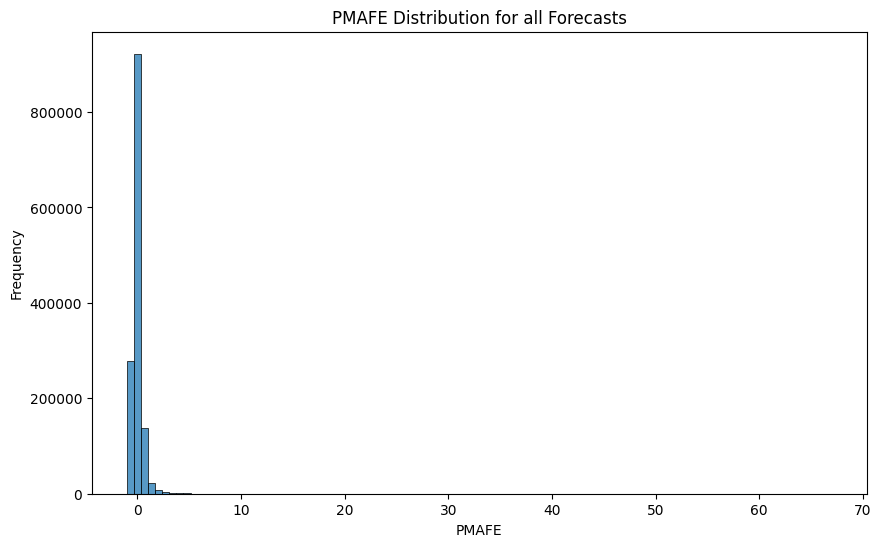

In [124]:
# most frequent PMAFE vales for all forecasts
plt.figure(figsize=(10, 6))
sns.histplot(df_forecasts['pmafe'], kde=False, bins=100)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Frequency")
plt.show()


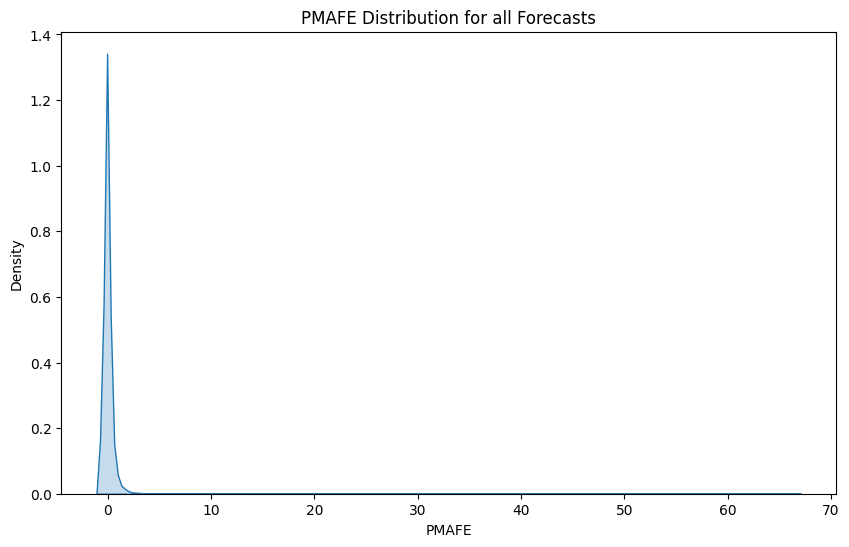

In [125]:
# density plot of PMAFE for all forecasts
plt.figure(figsize=(10, 6))
sns.kdeplot(df_forecasts['pmafe'], fill=True)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Density")
plt.show()

## Variant 2: Scaled accuracy

$$Acc_{ijt} = \frac{max AFE_{ijt} - AFE_{ijt}}{max AFE_{jt}- min AFE_{jt}}$$

where $max AFE_{jt}$ and $min AFE_{jt}$ are the maximum and minimum AFE for analysts following firm j in year t.

Source: Financial Analyst Characteristics and Herding Behavior in Forecasting MICHAEL B. CLEMENT and SENYO Y. TSE∗

In [ ]:
def calculate_scaled_acc(df):
    """_summary_
    
    Args:
        df (_type_): _description_
    """
    return df

# Export df

In [40]:
# write to csv
# name of the file to be saved as df_forecasts_pmafe.csv
import os 
new_folder_path = '../data/processed'  # Adjust the path as necessary

# Check if the new folder exists, if not, create it
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

# Define the file path where you want to save the dataframe
file_path = os.path.join(new_folder_path, 'forecasts_pmafe.csv')
df_forecasts.to_csv(file_path)

In [127]:
df_forecasts

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,afe_analyst_i,afe_analyst_i_avg,afe_mean_firm_j,pmafe
0,0000,TLMR,TALMER BANCORP,2500,72481,0.850,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,0.170,0.198000,0.166786,0.187152
1,0000,TLMR,TALMER BANCORP,149,119962,0.860,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,0.160,0.174286,0.166786,0.044968
2,0000,TLMR,TALMER BANCORP,1267,71182,0.890,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,0.130,0.158000,0.166786,-0.052677
3,0000,TLMR,TALMER BANCORP,149,119962,0.890,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,0.130,0.174286,0.166786,0.044968
4,0000,TLMR,TALMER BANCORP,873,79092,0.910,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,0.110,0.136667,0.166786,-0.180585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375246,ZYNX,ZYXI,ZYNEX INC,2709,122730,0.460,2022-12-31,2022-07-29,2022-07-29,0.44,2023-03-13,155 days,0.020,0.054000,0.035867,0.505576
1375247,ZYNX,ZYXI,ZYNEX INC,926,118308,0.420,2022-12-31,2023-01-18,2022-07-29,0.44,2023-03-13,155 days,0.020,0.033333,0.035867,-0.070632
1375248,ZYNX,ZYXI,ZYNEX,220,193620,0.423,2022-12-31,2023-01-06,2022-10-27,0.44,2023-03-13,65 days,0.017,0.023500,0.035867,-0.344796
1375249,ZYNX,ZYXI,ZYNEX,2709,122730,0.440,2022-12-31,2022-10-28,2022-10-28,0.44,2023-03-13,64 days,0.000,0.054000,0.035867,0.505576


In [126]:
# import companies' data with merged sic
merged_df_sic

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,gvkey,iid,ibtic,sic
0,0000,TLMR,TALMER BANCORP,2500,72481,0.850,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60.0
1,0000,TLMR,TALMER BANCORP,149,119962,0.860,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60.0
2,0000,TLMR,TALMER BANCORP,1267,71182,0.890,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60.0
3,0000,TLMR,TALMER BANCORP,149,119962,0.890,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,192458,01,0000,60.0
4,0000,TLMR,TALMER BANCORP,873,79092,0.910,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,192458,01,0000,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376485,ZYNX,ZYXI,ZYNEX INC,2709,122730,0.460,2022-12-31,2022-07-29,2022-07-29,0.44,2023-03-13,155 days,129441,01,ZYNX,38.0
1376486,ZYNX,ZYXI,ZYNEX INC,926,118308,0.420,2022-12-31,2023-01-18,2022-07-29,0.44,2023-03-13,155 days,129441,01,ZYNX,38.0
1376487,ZYNX,ZYXI,ZYNEX,220,193620,0.423,2022-12-31,2023-01-06,2022-10-27,0.44,2023-03-13,65 days,129441,01,ZYNX,38.0
1376488,ZYNX,ZYXI,ZYNEX,2709,122730,0.440,2022-12-31,2022-10-28,2022-10-28,0.44,2023-03-13,64 days,129441,01,ZYNX,38.0
